# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#sphx-glr-beginner-data-loading-tutorial-py) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](https://pytorch.org/docs/stable/distributions.html?highlight=transform#module-torch.distributions.transforms)!

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms #toTensor is the function you want to use
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# where are images location
img_dir = "./landmark_images"

## Catalog images using custom ImageCollection

Critical step for creating pytorch datasets and data loaders.  ImageCollection crawls through images in a folder to get the image path (i.e., absolute file path) of the image and the label of the image, which is the name of the directory the image is in. I use the absolute file path of the image as the id of the image.  The folders that the image is in, define the labels, so I just get the basename of the directory that the image is in, and store that as the label for the image.  The ImageCollection also creates the indices for the images and labels.

In [2]:
from image_data_utils import ImageCollection

ic = ImageCollection(img_dir, min_img_size_limit=(256,256))

train is a sub directory in the image directory?: True
test is a sub directory in the image directory?: True
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than limit:256. Width:800.
Image: ./landmark_images/train/48.Whitby_Abbey/43347caae033ca61.jpg Height:198 is less than l

In [3]:
print(f"Number Filtered: {ic.get_number_filtered()} Remaining images:{ic.get_number_images()}")

Number Filtered: 2280 Remaining images:268270


In [4]:
df = ic.describe_img_sizes()
df

,width,height
count,268270.000000,268270.000000
mean,751.828412,590.842577
std,97.490455,113.774570
min,286.000000,257.000000
25%,800.000000,533.000000
50%,800.000000,597.000000
75%,800.000000,600.000000
max,800.000000,800.000000


Above data frame show the results of filtering images who fail a minimum width and height size of (256X256).  Most images have a size of 800 x 600.  Max size is 800 x 800.  I wanted to reduce the amount of distortion that will happen when I do, when we apply the resize transform.

Below, I am testing the indexing of the ImageCollection to make sure the train and test images indices are not overlapping.

In [ ]:
folders = ['train','test']
for folder in folders:
    val = ic.get_folder_img_index_range(folder)
    print(f"{folder}: indicies {val}")

### OS WALK

In this section I am explore the os.walk function.  This was a precursor exploration so I could implement the ImageCollection class. 

Evauation:
 
 Each directory rooted at directory, yields 3-tuples, i.e., (dirpath, dirnames, filenames). Evaluating this for the Custom image class that I developed

 **Note: You do not need to run this section**

In [ ]:
directories = os.walk(img_dir+'/train')
structure = next(directories)

print(structure[1])

In [ ]:
structure = next(directories)
print(structure)

## Loading Data

1. Transform data.  Great Reference for possible transformation: https://pytorch.org/vision/main/auto_examples/plot_transforms.html?highlight=transforms
2. Create the data loader
3. Create the train, validation, and test data sets

I am finding that understanding the image format that each transform expects is key to avoiding errors. So format expect PIL format others expect Tensor format.

In [5]:
### TODO: Specify appropriate transforms, and batch_sizes
## Reference: mnist_mlp_exercise.ipynb
# How are you going to standardize the images
from torch import stack # not sure if I should be specificing stack each time or just at the end
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
image_size = 224


# REFERNCE: https://pytorch.org/vision/main/transforms.html#compositions-of-transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256), #resize all images so that the smallest side = 256 pixels
    transforms.ColorJitter(brightness=.5,hue=.3,contrast=.5,saturation=.2),
    transforms.RandomRotation(degrees=(0,180)), #randomly rotate between 0 and 180 degrees
    transforms.FiveCrop(size=(100,100)), # crops the given image into four corners and the central crop, returns a tuple
    transforms.Lambda(lambda crops: stack([transforms.PILToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: stack([crop.type(torch.float) for crop in crops])),
    transforms.Lambda(lambda crops: stack([transforms.Normalize(mean, std)(crop) for crop in crops])) #NOT WORKING
])

# Simplified transform - This works
transform_img = transforms.Compose([
    transforms.ToPILImage(), # Convert image data to PIL data type
    transforms.Resize((256,256)), #resize all image down to 256 X 256 pixels
    #transforms.CenterCrop(image_size), # center crop resultant image to be 224 X 224 image
    transforms.ColorJitter(brightness=.1,hue=.1,contrast=.1,saturation=.1),
    transforms.RandomRotation(degrees=15), #randomly rotate between 20 and -20 degrees
    transforms.ToTensor(), # Convert image data to Tensor data type
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the data to have a mean of .5 and standard deviation .5)
    ])

### [Side Note] Data Normalization

Data normalization is an important pre-processing step. It ensures that each input (each pixel value, in this case) comes from a standard distribution. That is, the range of pixel values in one input image are the same as the range in another image. This standardization makes our model train and reach a minimum error, faster!

Data normalization is typically done by subtracting the mean (the average of all pixel values) from each pixel, and then dividing the result by the standard deviation of all the pixel values. Sometimes you'll see an approximation here, where we use a mean and standard deviation of 0.5 to center the pixel values.

In [6]:
#data = ic.generate_train_valid_dataset(transform=transform_img)
#test_data = ic.generate_test_dataset(transform=transform_img)

data = ic.generate_train_valid_dataset(transform=transform_img)
test_data = ic.generate_test_dataset(transform=transform_img)
num_images = len(ic.img_labels)
num_labels = (data['train']).num_outputs()
print(f"Number of Labels: {num_labels} Number of Images: {num_images}")

Number of Labels: 50 Number of Images: 268270


## Create Data Loaders

DataLoader is an iterable that allows us to retrieve samples of a certain size (they call it mini batches). The sample are randomly selected from the data source you select. 

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [7]:
### TODO: Write data loaders for training, validation, and test sets

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20 #64
# percentage of training set to use as validation
valid_size = 0.2

In [8]:
"""DataLoader wraps an iterable around the Dataset to enable easy access to the samples."""
train_loader = torch.utils.data.DataLoader(
    data['train'],
    batch_size = batch_size,
    num_workers = num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    data['validation'],
    batch_size = batch_size,
    num_workers = num_workers,
)

test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    num_workers=num_workers
)

In [9]:
# Final dataset
loaders_scratch = {
    'train': train_loader, 
    'valid': valid_loader, 
    'test': test_loader
}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

In terms of my transformation, I randomly reviewed the train data and based on what I saw, I decided to augmented my data by adding some variation through random rotations and color jitter. I thought color was important for identifying locations, based on the quality of the camera and/or time of day the picture was taken the color could vary. Through exploration of the photos, I also saw a few rotations and translations so I added the RandomRotation transformation. I chose these transformation so that my architecture could also learn from orientation changes and color changes. 

Additionally, the images were not all the same size, so I wanted to make sure I captured the same amount of information regardless of the original size of the photo. So I resize all the photos to 256 x 256. I wanted the dimensions to squared and a base 2 exponential. Finally, I converted the image into a tensor and normalized that tensor so that my data was standardized.   

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Image Type: <class 'torch.Tensor'>
Feature batch shape: <class 'numpy.ndarray'>
Labels batch shape: <class 'tuple'>
Tuple Values: ('Edinburgh_Castle', 'Trevi_Fountain', 'Moscow_Raceway', 'Badlands_National_Park', 'Banff_National_Park', 'Gullfoss_Falls', 'Wroclaws_Dwarves', 'Edinburgh_Castle', 'Haleakala_National_Park', 'Delicate_Arch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


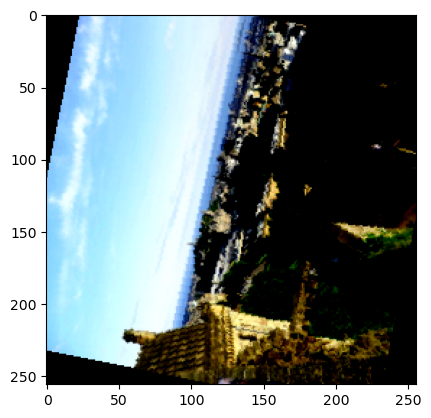

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

# obtain one batch of training images
train_images, train_labels = next(iter(train_loader)) # get the next batch of images
train_images = train_images.numpy()  # convert images from tensor to numpy for display

print(f"Feature batch shape: {type(train_images)}")
print(f"Labels batch shape: {type(train_labels)}")
print(f"Tuple Values: {train_labels}")

# Test 1 image
img = (train_images[0])
print(f"Original Shape: {img.shape}")
label = train_labels[0]
#plt.imshow(img, cmap="gray") # Crashes here

print(f"Label: {label}")

# See: https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
# Used vector (2,1,0) and how I would like to transpose the ndarray
img = np.transpose(img,(2,1,0)) #Why do I need to transpose?
print(f"Transposed Shape: {img.shape}")

plt.imshow(img)
plt.show()


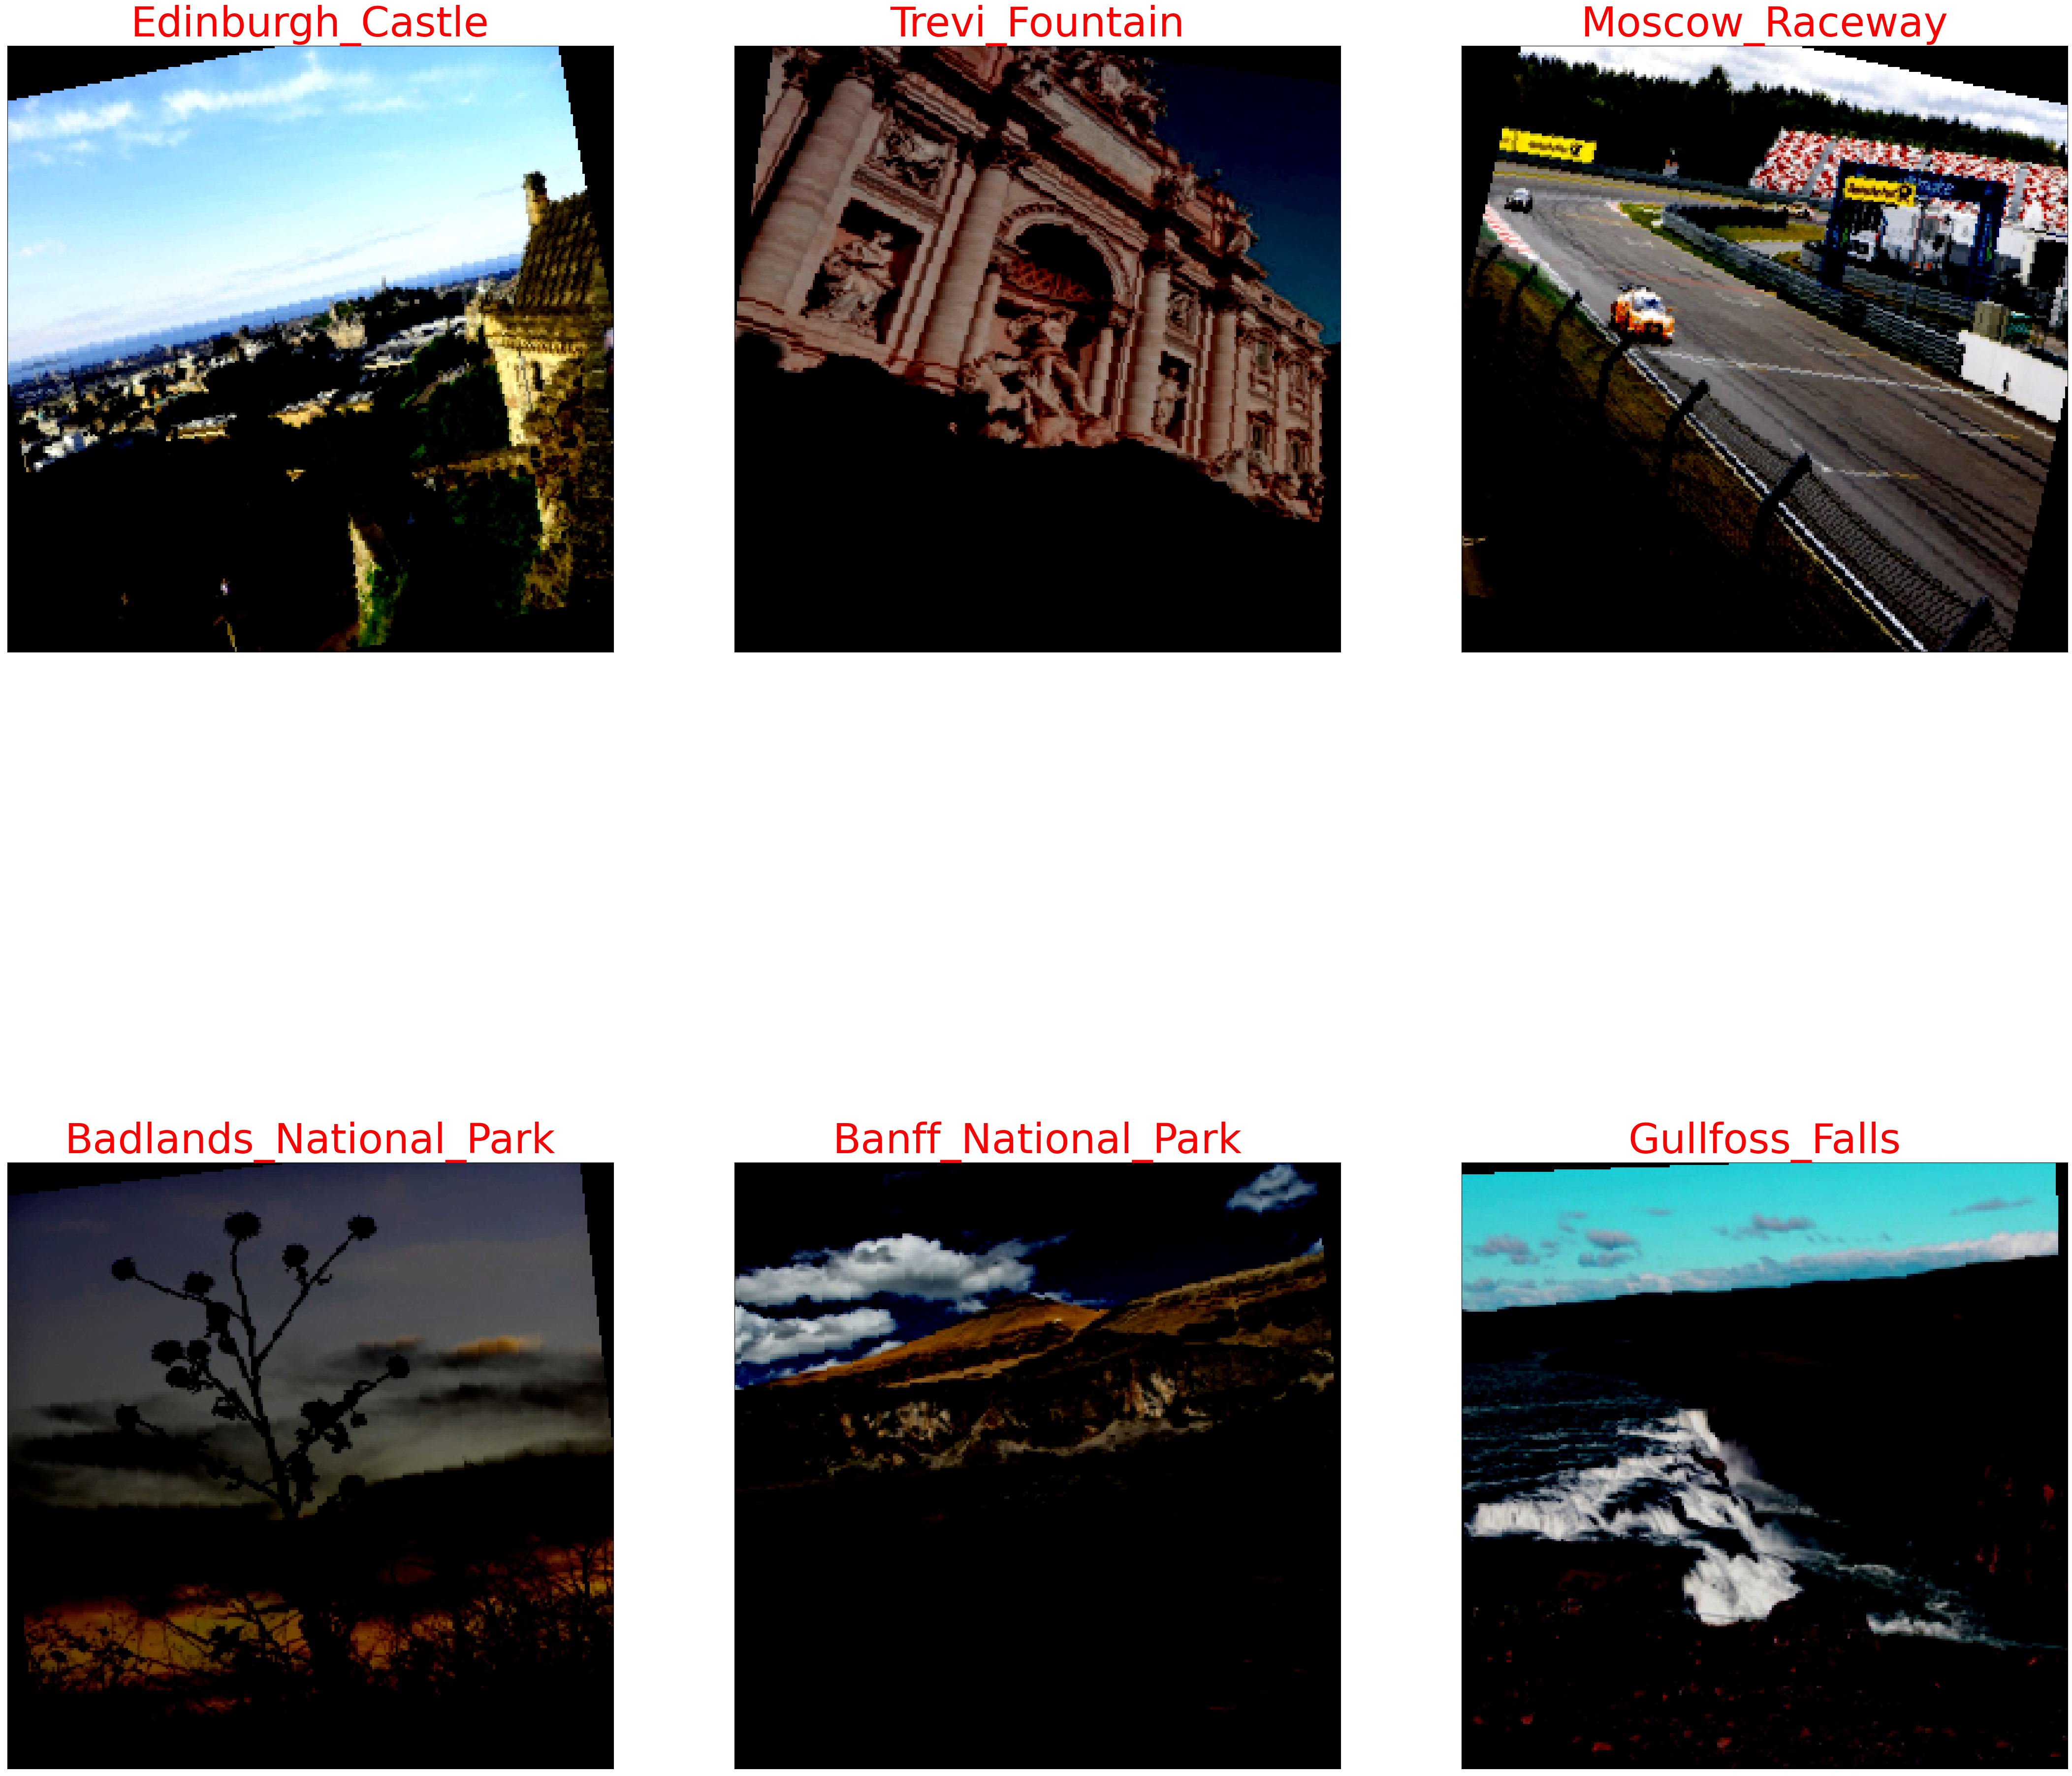

In [11]:

num_images = 6
num_columns = 3
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(54, 54)) # Canvas size of the figure
for idx in np.arange(num_images):
    ax = fig.add_subplot(
            int(np.floor(num_images/num_columns)), # number of rows
            num_columns, 
            idx+1, 
            xticks=[], 
            yticks=[]
        )
    img = train_images[idx]
    img = np.transpose(img,(1,2,0)).clip(0,1)
    ax.imshow(img)
    
    # print out the correct label for each image
    ax.set_title(f"{train_labels[idx]}", fontdict={'fontsize' : 60, 'color' : 'red'})
   

### Filtering non-informative images?

Looking at the images (e.g., Taj_Mahal), I found some pictures may have very little or no information.  So for example, all pixels are the same.  I should probably filter this out because it will reduce noise.  This should be true for all images (train and test).  So is there a way for me to create a cleaner that remove images with little variation?  Or will the neural network handle this?  

The network would possible figure this out.  But I could reduce processing time by removing?  I guess this is not a priority.  

In [12]:
# Image Size description
df = ic.describe_img_sizes()
df

,width,height
count,268270.000000,268270.000000
mean,751.828412,590.842577
std,97.490455,113.774570
min,286.000000,257.000000
25%,800.000000,533.000000
50%,800.000000,597.000000
75%,800.000000,600.000000
max,800.000000,800.000000


### Initialize use_cuda variable

In [13]:
# useful variable that tells us whether we should use the GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    use_cuda = False
else:
    print('CUDA is available!  Training on GPU ...')
    use_cuda = True

CUDA is available!  Training on GPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

### Vocab and Design Decisions

The problem is that people have used Loss in many ways.  So below I am identifying the differences.

#### The various Scoring and Loss Functions

- **scoring function** - the score that the base model f(x,W) = Wx+ b gives a point.  Where W are the weights, and x is the the example row from the dataset X.
- **error/Loss function** - is used for evaluating the error of an **indivdual train example (row)**. It is the penalty you attribute to error, where error is defined as ypred-yactual.
- **Cost/Loss function** - is used for calculating the average loss over the entire training set.  I like using the term cost function.
- **Scoring(h) function for hypertuning** - The metric that your fitting method optimizes for a given model with all hyperparameters set. The metric used to choose between your optimized model (i.e. how you pick the best hyperparameters). (So for GridSearchCV).

If you are trying to minimize the MAE, you would ideally want to have MAE as your cost function (so each model has the smallest possible MAE, given the hyperparameters) and have MAE as your Scoring(h) function (so you pick the best hyperparameters). If you use MSE as your cost function, and MAE as your scoring(h), you are unlikely to find the best answer.

[Cost/Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

### Optimizers

When training a model we try to minimize the Cost function to select the best **weights** for the training dataset.  Note, while finding the best **weights** for a training set, the hyperparameters linked to the selected algorithm (e.g., Random Forest, Multinormal regression, SVM), stays constant. Hyperparameter tuning is where we find multiple models using the the same training set (so Cost function to optimize weights still happen), but change the hyperparameter (e.g., Grid Search). 

Again, for optimization, we want to minimize the chosen Cost/Loss function. In calculus, to locate the mim/max you would find the point where the derivate is zero.  However, in most cases, it is really hard to compute the derivative of a Loss function because of the high dimensionality of the function (all those columns from the dataset!). Therefore, we use computational numerical analysis approaches to iteratively find the minimum (so approximate the derivative). There are many optimizers available that simulate the derivative in various manners. Additionally, optimizers is a computational process (e.g., gradient descent, stochastic gradient descent); thus, they have differing ways they use memory (what they remember as they do the simulation), cpu usage (how they do computation), speed (parallel or serial processes), and algorithmic behaviors to find the minimum. And each are better for different model algorithms (e.g., Regression, XGBoost, Random Forest). So there are design decisions here.

Types of Optimizers:

- Gradient Descent
- Stochastic Gradient Descent
- [Overview of Optimizers](./references/Overview_of_Optimizers.pdf)
- [Pytorch Optimzers](https://pytorch.org/docs/stable/optim.html#algorithms)

### Regularization

When we optimize, we are only using 1 dataset to find weights. However, the overall goal, is to build a model that can generalize to data that it has never seen. Sometimes, optimizer may be too good in finding the best model for the particular training dataset.  So the model performs well on training set, but when applied to the validation or test set, the performance significantly differs (i.e., Overfitting). Often when you overfit, the optimizer has created a model that is overly complex, in order to fit the specific data points of the training set.

Regularization tries to prevent the optimization process from overfitting. Regularization introduces randomness and penalties around complex into the optimization process. So now the optimizer is not just looking for the best weights for the training dataset but has to also balance that with the reduction of complexity. So we have basically added another constraint for the optimizer to take into consideration when optimizing.  This term is really about model generalization. There are many types of Regularization.

Types of Regularization -

- L1
- L2 -
- Dropout - neural networks.  Randomly drop out nodes during training
- Early Stopping - For example, with Random Forest, you give it a minimal node size (so a node cannot have less than 20 values).  Or tree can only branch for this many levels.
- Data Augmentation - Image manipulations (rotations, color changes, five crop).  Adding variation to the training dataset, so not to optimize to the training set. 
- Batch Normalization
- [Regularization Article](https://medium.com/analytics-vidhya/understanding-regularization-with-pytorch-26a838d94058)

### Performance Metrics

- [Classifier Performance metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#classification-metrics)
- [Regression Performance metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#regression-metrics)
- [Multi-Label Ranking metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#multilabel-ranking-metrics)
- [Clustering Metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#clustering-metrics)

In [14]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    
    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Reference about Adam optimizer: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    return(optimizer)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

### Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images. Convolutional layer consists of filters and feature maps. Where filters carry the input weights according to that output value and the **feature map** is the output according to the weight applied on the filter.
* [Max Pooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer. Max-pooling is a form of Regularization.  It generalizes the data by selecting the max value of a filter region and using that as the representative. There are other Pooling Layers, such as averaging the pixel (i.e., Average Pooling Layers), but this results in smoothing versus high contrast. The basic work of the pooling layer is to downsample the **feature map**. Good Reference: <https://analyticsindiamag.com/comprehensive-guide-to-different-pooling-layers-in-deep-learning/>

* ![Pooling Layer](./references/pooling_layers.png)

* ![Max Pooling Layer](./references/max_pooling_ex.png)  Shows an example of what max pooling does.

* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code. Note: the CNN is going to pull out the relevant "features" for distinguishing for identifying the different classes (locations).

<img src='references/2_layer_conv.png' height=80% width=80% />

![Another example of CNN](./references/cnn.png)

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `((W−F)+(2P))/S)+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output, `((7-3) + (2*0))/1) + 1 = 5`. With stride 2 we would get a 3x3 output, `((7-3) + (2*0))/2) + 1 = 3`.

#### Convolution Layer in pytorch

![Pytorch Convolution Layer Documentation](./references/pytorch_convolution_layers.png)

#### More Vocab

- **Filter:** A set of weights in a 2D format.  The weights are defined in a way to identify patterns of intensity changes, particularly around edges. High Pass Filter, Low Pass Filter.  Filters are sometime referred to as **Kernels**.
- **Stride:** How many pixels to jump as you move the filter over the image before it does the convolution. Stride =1, means move the filter 1 over before applying the convolution. So you are not skipping any pixels. Reduces the size (x,y) of the final filtered image.  So if stride is two, the dimensions of the final image will be reduced by half.  I see this as another way of generalizing your network.
- **Edge handling:** Kernel convolution relies on centering a pixel and looking at it's surrounding neighbors. So, what do you do if there are no surrounding pixels like on an image corner or edge? Well, there are a number of ways to process the edges, which are listed below. It’s most common to use padding, cropping, or extension. In extension, the border pixels of an image are copied and extended far enough to result in a filtered image of the same size as the original image.
- **Padding:** The image is padded with a border of 0's, black pixels.

- **Convolution:** See image below.  It a process for applying a filter. Steps: Center a filter full of weights on a pixel. Multiple the weights of a filter on the pixel values that it overlaps.  Then sum up the values to get the new value for the center pixel.

<img src='references/convolution_layers.gif' height=50% width=50% />

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self, n_outputs = num_labels):
        """Initializing the neural network

        In Pytorch, to define any neural network you have to name and define any layers that have any
        learned weight values. 

        Args:
            n_outputs (int, optional): The number of target labels. Defaults to 50.
        """
        super(Net, self).__init__()

        self.num_output_nodes = n_outputs
        
        ## Define layers of a CNN
        ## Reference: https://towardsdatascience.com/pytorch-how-and-when-to-use-module-sequential-modulelist-and-moduledict-7a54597b5f17
        self.features = nn.Sequential(
            OrderedDict(
                [   
                    ('conv_layer1',nn.Conv2d(3, 16, 3, padding=1)), #depth is 3, size = (256,256)
                    ('conv_layer2',nn.Conv2d(16, 32, 3, padding=1)), #depth is 16, size = (256,256)
                    ('maxpooling_layer1',nn.MaxPool2d(4,2)), #size = (128,128)
                    #depth = 32, also cut the resultant filtered image in half with stride =2
                    ('conv_layer3',nn.Conv2d(32, 64, 3, padding=1, stride=2)), #depth=64, size=(128,128)
                    ('maxpooling_layer1',nn.MaxPool2d(4,2)), #depth=64, size=(64,64)
                ]
            )
        )

        # Normal Neural Network
        self.image_input_size = 64 #Size of final images from feature functions
        self.num_hidden1_nodes = 64
        self.num_hidden2_nodes = 50
        
        
        ## Define Layers for the Linear Neural Network
        ## Need to determine the final size from the convolution
        self.model = nn.Sequential(
            OrderedDict(
                [
                    ('fc1', nn.Linear(self.image_input_size, self.num_hidden1_nodes)), # fully connected hidden layer 1
                    ('dropout1', nn.Dropout(.2)), # dropout layer to help reduce overfitting
                    ('relu1', nn.ReLU()), # activation function. Makes sure values are in a consistent range
                    ('fc2', nn.Linear(self.num_hidden1_nodes, self.num_hidden2_nodes)), # fully connected hidden layer 
                    ('dropout2', nn.Dropout(.2)), # to dropout layer to help reduce overfitting
                    ('relu2',nn.ReLU()), # activation function.  Makes sure values are in a consistent range
                    ('fc3', nn.Linear(self.num_hidden2_nodes, self.num_output_nodes)), # output layer
                    #('softmax', nn.Softmax(dim=1)) # class probabilities.  Don't need this because I am using cross-entropies optimization
                ]
            )
        )          
    
    def forward(self, x):
        ## Define forward behavior   
        x = self.features()
        print(f"x.size(0) = {x.size(0)}")
        x = x.view(-1, x.size(0))
        #x = x.view(-1, self.image_input_size * self.image_input_size)
        x = self.model(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

## Connect to EC2

I am connecting to EC2 in order to run on a GPU.  Please see below on how to set it up. I am going to try the lower EC2 instance type: `g4dn.xlarge`. It is an Intel based server. Cost is $0.51 per hour on a Linux On-Demand machine. The price is current as of 10/1/2022. The instance **1 GPU**, **4vCPU**, **16GB RAM**, **45 GB** storage, Moderate Network Performance.

Reference: <https://medium.com/@christyjacob4/using-vscode-remotely-on-an-ec2-instance-7822c4032cff>

Steps:

1. Make sure **Remote-SSH** from Microsoft extension is installed for VSCode.
2. Use the AWS calculator: <https://calculator.aws/>, to estimate your usage cost.  Pretty cool.  It estimated that if I used the selected instance for 7 hours a week (so I would need to turn off the instance) for 4 weeks, it would cost me $23.15 a month: $20.15 for the EC2 instance and $3.00 for the 30GB EBS attached storage.
3. Create and configure your EC2 instance so that only your machine can ssh into the instance.
    - Setup your security group to only allow inbound from SSh from your computer.  And outbound can go anywhere.
    - Setup IAM so that the ec2 instance can access S3
    - Try to get a spot instance if possible.
4. Once the ec2 instance has been launched
    - Run the ec2-setup.sh script on the remote ec2 instance
    - Install the Pylance extension on the remote ec2 instance
    - Open Jupyter notebook: landmark.ipynb
    - Set the interpret to the pytorch 3.9.13 interpreter
5. When you are done remember to save changed project files to S3

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I did an initial guess of what the architecture should.  I started with three convolution layers and two max-pooling layers.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss [Ugochi: Note sure if I did this right]
            train_loss += loss.item()*data.size(0)

        if train_loss == np.nan:
            raise ValueError("train loss is nan")

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        # For Loop: Sums all the loss across the batch items
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        if valid_loss == np.nan:
            raise ValueError("valid loss is nan")
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss)
            )
            torch.save(model.state_dict(), 'model_landmark.pt')
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [ ]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n) # Using general rule that weights should 1/sqrt(number of features)
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': None, 'valid': None, 'test': None}





### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
## TODO: select loss function
criterion_transfer = None


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    pass

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
## TODO: Specify model architecture

model_transfer = None




#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'



#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    pass


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

